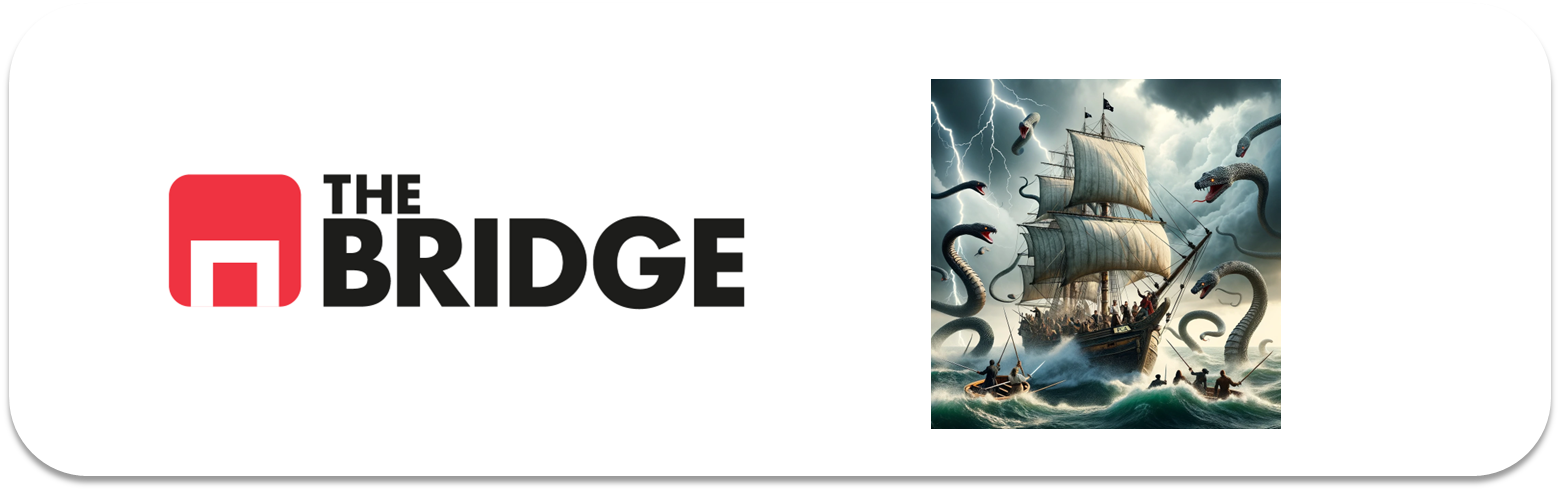

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import balanced_accuracy_score

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


C:\Users\Xián\AppData\Local\Temp\ipykernel_11732\1291901979.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.qcut(df_clean[col].rank(method='first'), q=3, labels=[0, 1, 2], duplicates='drop')  # 3 niveles
C:\Users\Xián\AppData\Local\Temp\ipykernel_11732\1291901979.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = pd.qcut(df_clean[col].rank(method='first'), q=3, labels=[0, 1, 2], duplicates='drop')  # 3 niveles
C:\Users\Xián\AppData\Local\Temp\ipykernel_11732\1291901

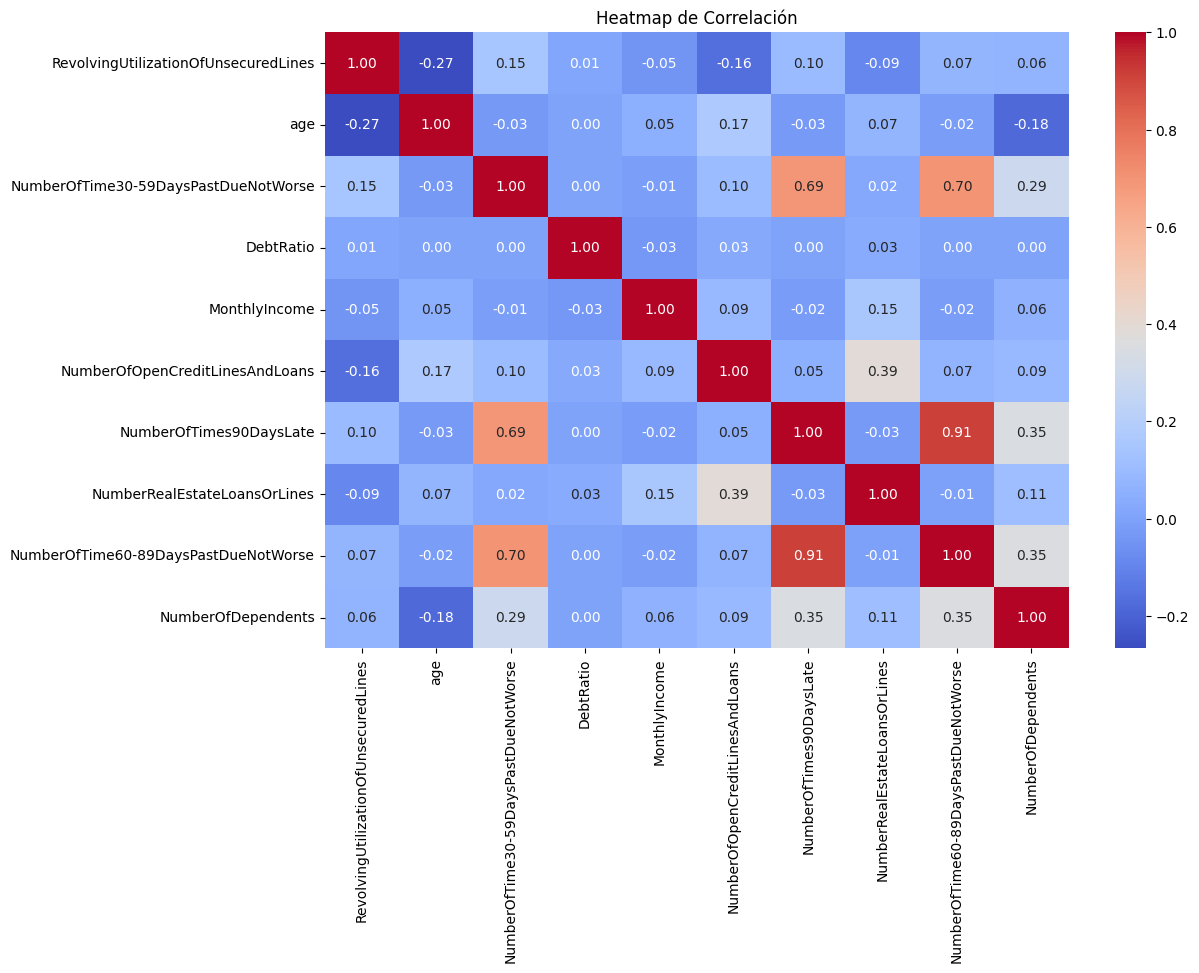

                  Model Feature Selection  Mean Recall
0         Random Forest             KBest     0.542703
1         Random Forest                MI     0.544478
2         Random Forest               SFM     0.530079
3         Random Forest               RFE     0.564915
4   Logistic Regression             KBest     0.506386
5   Logistic Regression                MI     0.502513
6   Logistic Regression               SFM     0.502912
7   Logistic Regression               RFE     0.505521
8                   SVM             KBest     0.518656
9                   SVM                MI     0.500000
10                  SVM               SFM     0.500000
11                  SVM               RFE     0.519407
Best Params: {'n_estimators': 100}
Final Test Recall: 0.5483572141157899


In [ ]:
# Cargar el dataset
file_path = "./data/credit_npo.csv"  # Asegúrate de que el archivo esté en la misma ruta del script
df = pd.read_csv(file_path)

# 1. Eliminación de filas con valores nulos
df_clean = df.dropna()

# 2. Identificar columnas "NumberOf..." para convertir a categóricas con 2-3 niveles
number_columns = [col for col in df_clean.columns if "NumberOf" in col]

# Convertir en categorías de pocos niveles usando cuantiles
for col in number_columns:
    if df_clean[col].nunique() > 1:  # Verificar si hay más de un valor único
        df_clean[col] = pd.qcut(df_clean[col].rank(method='first'), q=3, labels=[0, 1, 2], duplicates='drop')  # 3 niveles

# Separar variables independientes y dependientes
X = df_clean.drop(columns=["SeriousDlqin2yrs"])
y = df_clean["SeriousDlqin2yrs"]

# Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar las features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2.1 Análisis visual combinado con correlación y covarianza
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(X_train_scaled, columns=X_train.columns).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlación")
plt.show()

# 2.2 Selección de features numéricas con SelectKBest y ANOVA
select_kbest = SelectKBest(score_func=f_classif, k=min(6, X_train.shape[1]))
X_train_kbest = select_kbest.fit_transform(X_train_scaled, y_train)
selected_features_kbest = X_train.columns[select_kbest.get_support()].tolist()

# 2.3 Selección de features categóricas con Mutual Information
mutual_info = SelectKBest(score_func=mutual_info_classif, k=min(6, X_train.shape[1]))
X_train_mi = mutual_info.fit_transform(X_train_scaled, y_train)
selected_features_mi = X_train.columns[mutual_info.get_support()].tolist()

# 2.4 Selección de features con modelo intermedio (SelectFromModel con RandomForest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
select_from_model = SelectFromModel(rf, prefit=True)
selected_features_sfm = X_train.columns[select_from_model.get_support()].tolist()

# 2.5 Selección de features con RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=min(6, X_train.shape[1]))
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
selected_features_rfe = X_train.columns[rfe.support_].tolist()

# 2.6 Selección de features con SFS
sfs = SFS(LogisticRegression(), k_features=min(6, X_train.shape[1]), forward=True, floating=False, scoring='balanced_accuracy', cv=5)
sfs.fit(X_train_scaled, y_train)
selected_features_sfs = list(sfs.k_feature_names_)

# 2.7 Hard-voting para seleccionar features comunes
final_features = list(set(selected_features_kbest) & set(selected_features_mi) & set(selected_features_sfm) & set(selected_features_rfe) & set(selected_features_sfs))
final_features = [f for f in final_features if f in X_train.columns]

# 3. Comparación de Modelos
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

param_grids = {
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
}

results = []
for model_name, model in models.items():
    for feature_set, feature_list in zip(["KBest", "MI", "SFM", "RFE", "SFS", "Voting"],
                                         [selected_features_kbest, selected_features_mi, selected_features_sfm, selected_features_rfe, selected_features_sfs, final_features]):
        valid_features = [f for f in feature_list if f in X_train.columns]
        if not valid_features:
            continue  # Evitar listas vacías
        X_train_selected = X_train_scaled[:, [X_train.columns.get_loc(f) for f in valid_features]]
        scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='balanced_accuracy')
        results.append({
            "Model": model_name,
            "Feature Selection": feature_set,
            "Mean Recall": np.mean(scores)
        })

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# 4. Optimización del Mejor Modelo
if not df_results.empty:
    best_model_row = df_results.loc[df_results["Mean Recall"].idxmax()]
    best_model = models[best_model_row["Model"]]
    best_feature_set = best_model_row["Feature Selection"]
    best_features = selected_features_kbest if best_feature_set == "KBest" else (
        selected_features_mi if best_feature_set == "MI" else (
            selected_features_sfm if best_feature_set == "SFM" else (
                selected_features_rfe if best_feature_set == "RFE" else (
                    selected_features_sfs if best_feature_set == "SFS" else final_features))))
    best_features = [f for f in best_features if f in X_train.columns]
    
    grid = GridSearchCV(best_model, param_grids[best_model_row["Model"]], scoring='balanced_accuracy', cv=5)
    grid.fit(X_train_scaled[:, [X_train.columns.get_loc(f) for f in best_features]], y_train)
    print("Best Params:", grid.best_params_)

    # Evaluar en Test
    y_pred_test = grid.best_estimator_.predict(X_test_scaled[:, [X_train.columns.get_loc(f) for f in best_features]])
    final_test_recall = balanced_accuracy_score(y_test, y_pred_test)
    print("Final Test Recall:", final_test_recall)


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.